## Proves constel·lacions


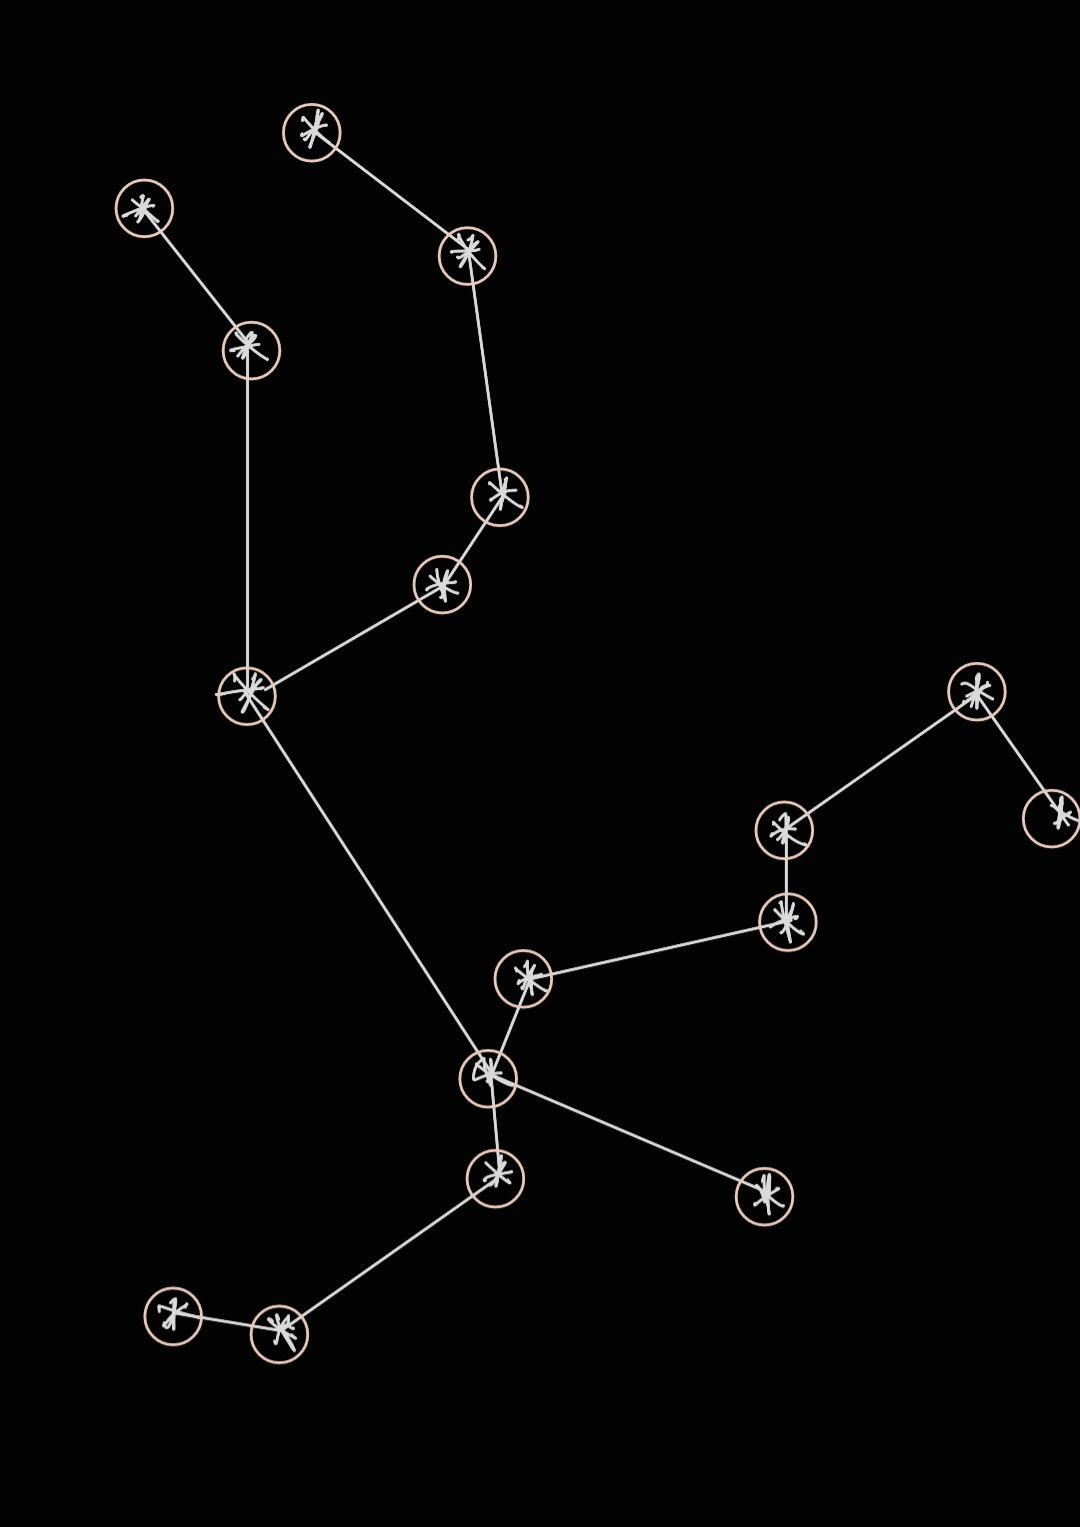

In [4]:
from PIL import Image

image = Image.open('image0.jpg')
image.show()

Radio moda (más frecuente): 30 (aparece 9 veces)
Radio promedio: 36.63
Rango aceptable (basado en moda): [24.00, 36.00]
Círculos detectados inicialmente: 27
Círculos rechazados por tamaño: 8
Círculos rechazados por pocos píxeles blancos: 2
Círculos filtrados finales: 17


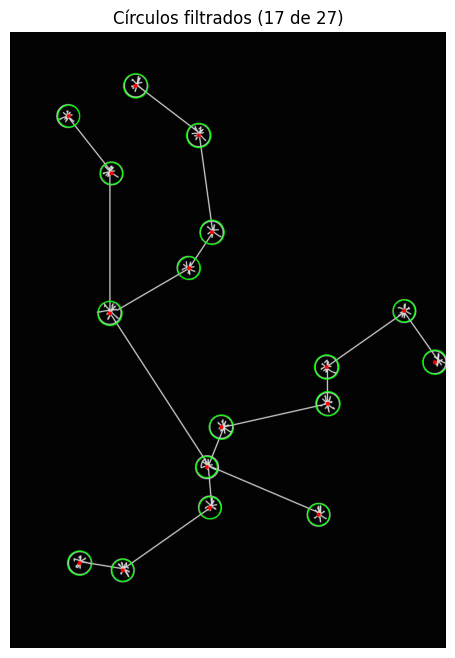

In [23]:
import cv2
from scipy import stats
# No need to import numpy or matplotlib, and variables are already defined

# Convert PIL image to numpy array and grayscale if needed
image_np = np.array(image)
if image_np.ndim == 3:
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image_np

# Binarizar la imagen para contar píxeles blancos
_, binary_image = cv2.threshold(image_gray, 50, 255, cv2.THRESH_BINARY)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    image_gray, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2, 
    minDist=30, 
    param1=50, 
    param2=30, 
    minRadius=10, 
    maxRadius=100
)

output_circles = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

centroids = []
filtered_circles = []

if circles is not None:
    circles = np.uint16(np.around(circles[0]))
    
    # Calcular la moda del radio (el radio más frecuente)
    radii = [r for (x, y, r) in circles]
    mode_result = stats.mode(radii, keepdims=True)
    mode_radius = mode_result.mode[0]
    mode_count = mode_result.count[0]
    
    # Calcular promedio también para comparación
    mean_radius = np.mean(radii)
    
    # Definir rango aceptable basado en la moda (±15% de la moda)
    threshold = 0.2
    min_radius = mode_radius * (1 - threshold)
    max_radius = mode_radius * (1 + threshold)
    
    print(f"Radio moda (más frecuente): {mode_radius} (aparece {mode_count} veces)")
    print(f"Radio promedio: {mean_radius:.2f}")
    print(f"Rango aceptable (basado en moda): [{min_radius:.2f}, {max_radius:.2f}]")
    print(f"Círculos detectados inicialmente: {len(circles)}")
    
    # Umbral de píxeles blancos (ajustable según tus necesidades)
    # Porcentaje mínimo del área del círculo que debe estar ocupado
    white_pixel_threshold = 0.15  # 30% del área debe tener píxeles blancos
    
    circles_rejected_by_size = 0
    circles_rejected_by_white_pixels = 0
    
    # Filtrar círculos por tamaño y contenido de píxeles blancos
    for (x, y, r) in circles:
        if min_radius <= r <= max_radius:
            # Crear máscara circular
            mask = np.zeros(binary_image.shape, dtype=np.uint8)
            cv2.circle(mask, (x, y), r, 255, -1)
            
            # Contar píxeles blancos dentro del círculo
            white_pixels = cv2.countNonZero(cv2.bitwise_and(binary_image, mask))
            
            # Calcular área del círculo
            circle_area = np.pi * (r ** 2)
            
            # Calcular porcentaje de píxeles blancos
            white_pixel_ratio = white_pixels / circle_area
            
            # Filtrar por píxeles blancos
            if white_pixel_ratio >= white_pixel_threshold:
                cv2.circle(output_circles, (x, y), r, (0, 255, 0), 2)
                cv2.circle(output_circles, (x, y), 5, (255, 0, 0), -1)
                centroids.append((x, y))
                filtered_circles.append((x, y, r))
            else:
                circles_rejected_by_white_pixels += 1
        else:
            circles_rejected_by_size += 1

print(f"Círculos rechazados por tamaño: {circles_rejected_by_size}")
print(f"Círculos rechazados por pocos píxeles blancos: {circles_rejected_by_white_pixels}")
print(f"Círculos filtrados finales: {len(centroids)}")

plt.figure(figsize=(8, 8))
plt.imshow(output_circles)
plt.title(f'Círculos filtrados ({len(centroids)} de {len(circles) if circles is not None else 0})')
plt.axis('off')
plt.show()

Número de componentes conectados detectados: 17


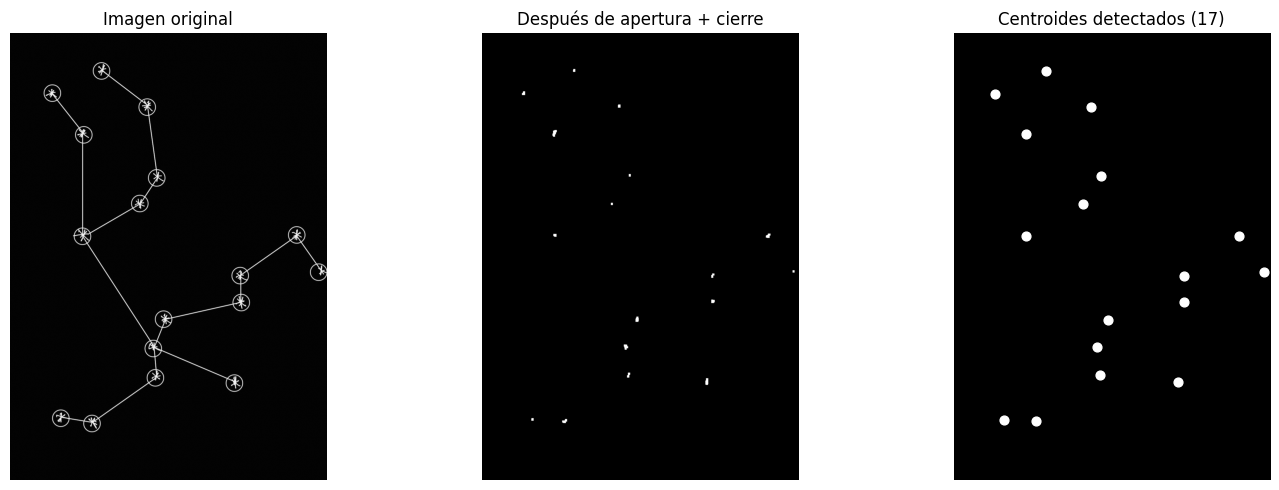

In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Convert PIL image to numpy array
image_np = np.array(image)

# Convert to grayscale if needed
if image_np.ndim == 3:
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image_np

# Binarizar la imagen (umbral adaptativo o fijo)
# Opción 1: Umbral fijo
_, binary = cv2.threshold(image_gray, 50, 255, cv2.THRESH_BINARY)

# Opción 2: Umbral adaptativo (mejor para iluminación desigual)
# binary = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                cv2.THRESH_BINARY, 11, 2)

# Definir kernel
kernel = np.ones((7, 7), np.uint8)

# Aplicar apertura (elimina ruido pequeño)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

# Aplicar cierre (rellena huecos pequeños)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

# Detectar componentes conectados
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing)

print(f"Número de componentes conectados detectados: {num_labels - 1}")  # -1 para excluir fondo

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Imagen original')
axes[0].axis('off')

axes[1].imshow(closing, cmap='gray')
axes[1].set_title('Después de apertura + cierre')
axes[1].axis('off')

axes[2].imshow(closing, cmap='gray')
axes[2].scatter(centroids[1:, 0], centroids[1:, 1], color='white', s=40)
axes[2].set_title(f'Centroides detectados ({num_labels - 1})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

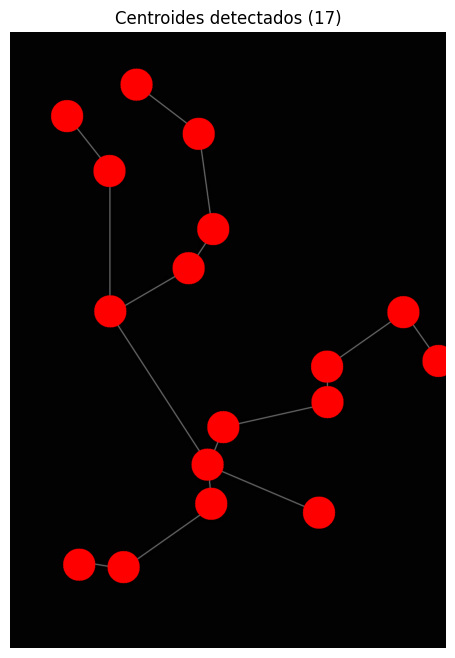

In [3]:
# Crear imagen de salida con cv2
output_image = image_np.copy()

# Superponer la imagen binaria con transparencia
closing_rgb = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)
output_image = cv2.addWeighted(output_image, 0.5, closing_rgb, 0.5, 0)

# Dibujar centroides como círculos rojos
for centroid in centroids[1:]:
    cv2.circle(output_image, (int(centroid[0]), int(centroid[1])), 40, (255, 0, 0), -1)

# Guardar la imagen
cv2.imwrite('output_with_centroids.png', cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

# Mostrar
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.title(f'Centroides detectados ({num_labels - 1})')
plt.axis('off')
plt.show()

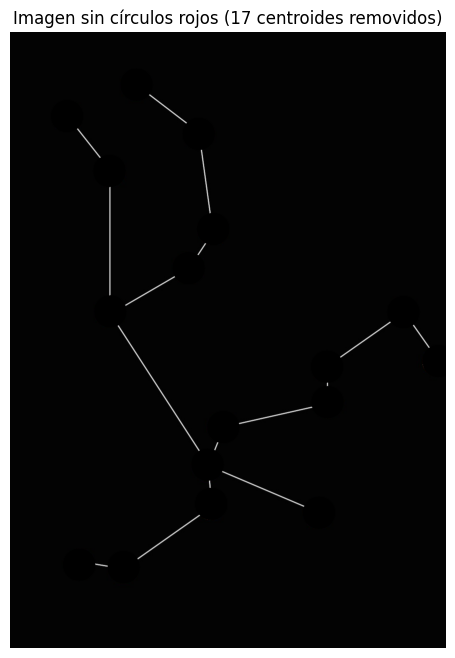

In [4]:
# Crear imagen de salida con cv2
output_image = image_np.copy()

# Crear una máscara para los centroides
mask = np.zeros(output_image.shape[:2], dtype=np.uint8)

# Dibujar círculos blancos en la máscara (donde están los centroides)
for centroid in centroids[1:]:
    cv2.circle(mask, (int(centroid[0]), int(centroid[1])), 40, 255, -1)

# Invertir la máscara (ahora los círculos son negros y el resto blanco)
mask_inv = cv2.bitwise_not(mask)

# Aplicar la máscara a la imagen original para quedarte con todo excepto los círculos rojos
output_image_without_red = cv2.bitwise_and(output_image, output_image, mask=mask_inv)

# Guardar la imagen
cv2.imwrite('output_without_red_circles.png', cv2.cvtColor(output_image_without_red, cv2.COLOR_RGB2BGR))

# Mostrar
plt.figure(figsize=(8, 8))
plt.imshow(output_image_without_red)
plt.title(f'Imagen sin círculos rojos ({num_labels - 1} centroides removidos)')
plt.axis('off')
plt.show()

Líneas detectadas: 48


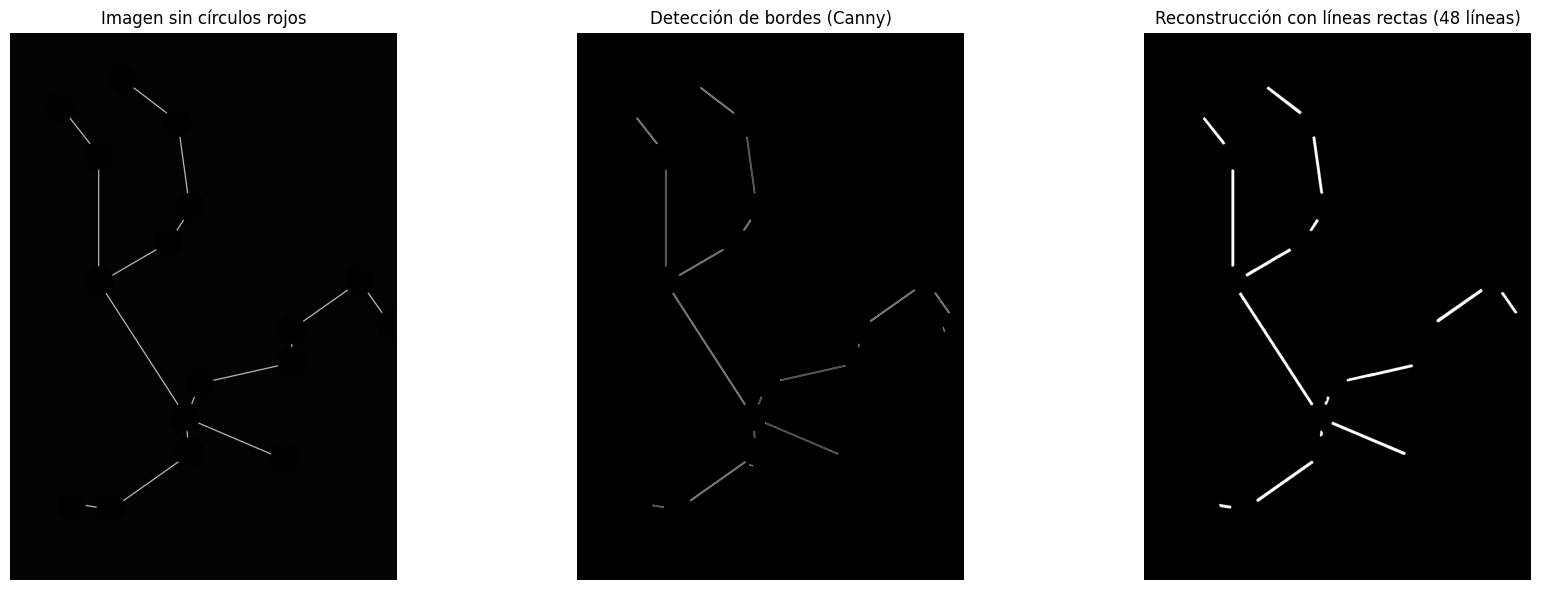

True

In [5]:
# Convertir a escala de grises
gray = cv2.cvtColor(output_image_without_red, cv2.COLOR_RGB2GRAY)

# Detectar bordes con Canny
edges = cv2.Canny(gray, 30, 100, apertureSize=3)

# Detectar líneas con Hough Line Transform
lines = cv2.HoughLinesP(
    edges, 
    rho=1,
    theta=np.pi/180,
    threshold=15,
    minLineLength=5,
    maxLineGap=3
)

# Crear imagen negra del mismo tamaño
reconstructed = np.zeros_like(output_image_without_red)

# Dibujar todas las líneas detectadas
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(reconstructed, (x1, y1), (x2, y2), (255, 255, 255), 3)
    
    print(f"Líneas detectadas: {len(lines)}")
else:
    print("No se detectaron líneas")

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(output_image_without_red)
axes[0].set_title('Imagen sin círculos rojos')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Detección de bordes (Canny)')
axes[1].axis('off')

axes[2].imshow(reconstructed)
axes[2].set_title(f'Reconstrucción con líneas rectas ({len(lines) if lines is not None else 0} líneas)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Guardar la imagen reconstruida
cv2.imwrite('reconstructed_with_lines.png', cv2.cvtColor(reconstructed, cv2.COLOR_RGB2BGR))

Radio moda (más frecuente): 30 (aparece 9 veces)
Radio promedio: 36.63
Rango aceptable (basado en moda): [24.00, 36.00]
Círculos detectados inicialmente: 27
Círculos rechazados por tamaño: 8
Círculos rechazados por pocos píxeles blancos: 2
Círculos filtrados finales: 17


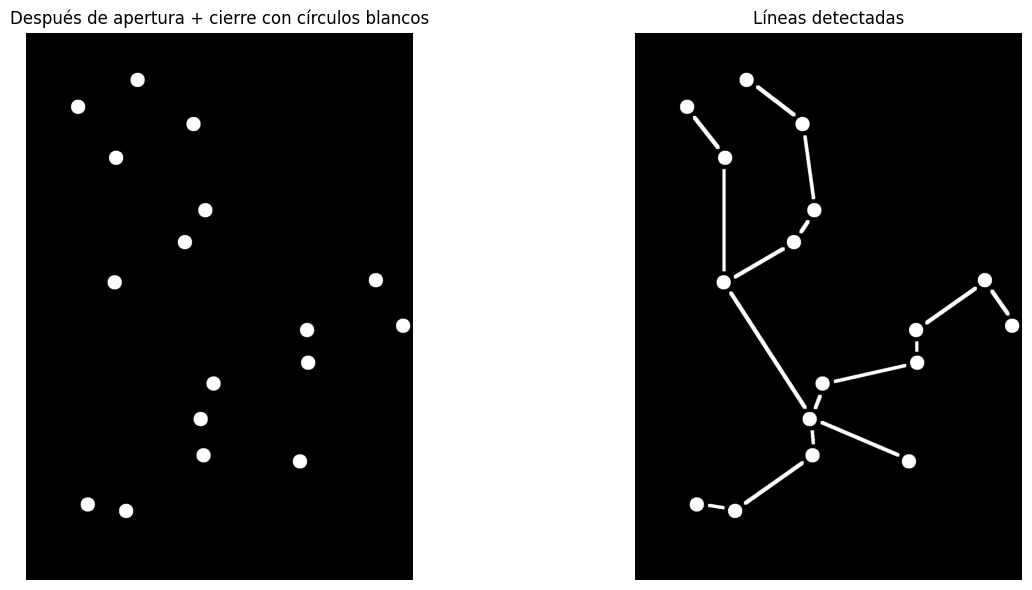

In [1]:
from constellation_processing import process_constellation_image_new, visualize_results
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Ruta de la imagen
image_path = "./image0.jpg"

# Procesar la imagen
image_circles, image_lines, output_filtered = process_constellation_image_new(image_path)

# Visualizar resultados
visualize_results(image_circles, output_filtered)